# Assumptions:
1. Assume we know the number of board seats sought at the time of success prediction. For records with non-zero number of board seats sought, we assume missing in number of board seats gained mean zero. (Fact: number of board seats gained does not have zero in it.)
2. Assume all the information in X is available before announncement
3. For board seat control, define seat gained ratio as number of board seat gained over number of board seat sought. Define seat gained success as success if seat gained ratio is equal or greater than one, partial success if seat gained ratio is larger than zero but smaller than one, and fail if seat gained ratio is zero.
4. For total number of board seats being zero, we assume it's missing value.

In [1]:
import numpy as np
import pathlib as pa
import os
import pandas as pd
import tensorflow as tf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#Preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.model_selection as ms
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import category_encoders as ce
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

#Model
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt


In [2]:
BASE_DIR = pa.Path(os.path.abspath('')).parent
DATA_DIR = BASE_DIR.joinpath('data')
WORK_DIR = BASE_DIR.joinpath('Model')

In [3]:
# read in data
all_data_csv = list(DATA_DIR.glob('**/*.csv'))
all_data_csv = [str(path) for path in all_data_csv]

all_data_txt = list(DATA_DIR.glob('**/*.txt'))
all_data_txt = [str(path) for path in all_data_txt]

BASE_DATA =pd.read_csv(all_data_csv[1])
# BASE_DATA =pd.read_csv(all_data_csv[1])

# price_histroy = pd.read_csv(all_data_txt[0])

full_name = list(BASE_DATA.keys())

In [6]:
# Group governance_demand as in governance_demand prediction
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Board Seats (activist group)'] = 'Board'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Other Governance Enhancements'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Compensation Related Enhancements'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Remove Director(s)'] = 'Officer_Demand'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Social/Environmental/Political Issues'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Remove Takeover Defenses'] = 'Operations'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Add Independent Directors'] = 'Officer_Demand'
BASE_DATA['governance_demand'][BASE_DATA['governance_demand'] == 'Remove Officer(s)'] = 'Officer_Demand'


BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Other Capital Structure Related, Increase Leverage, etc.'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Breakup Company, Divest Assets/Divisions'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Fund specific: Realize Net Asset Value/Open-End a Closed-End Fund'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Fund specific: Change Investment Strategy'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'General Discussions/Underperformance'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Review Strategic Alternatives'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Block Acquisition/Agitate for Lower Price (Shareholder of Acquirer)'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Seek Sale/Merger/Liquidation'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Block Merger/Agitate for Higher Price (Shareholder of Target)'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Potential Acquisition (Friendly and Unfriendly)'] = 'MA'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Return Cash via Dividends/Buybacks'] = 'Operation'
BASE_DATA['value_demand'][BASE_DATA['value_demand'] == 'Separate Real Estate/Create REIT'] = 'Operation'

#WATCH OUT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != '13D Filer - No Publicly Disclosed Activism']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Remove Director(s), No Dissident Nominee to Fill Vacancy']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Remove Officer(s)']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Public Short Position/Bear Raid']
BASE_DATA = BASE_DATA[BASE_DATA['campaign_objective_primary'] != 'Vote For a Management Proposal/Support Management']


BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Board Representation'] = 'Add_Directors'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Board Control'] = 'Add_Directors'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Maximize Shareholder Value'] = 'Generic_Objective'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Enhance Corporate Governance'] = 'Generic_Objective'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Hostile/Unsolicited Acquisition'] = 'Facilitate_MA'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Vote/Activism Against a Merger'] = 'Block_MA'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Vote For a Stockholder Proposal'] = 'Vote_For_Dissident'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Vote Against a Management Proposal'] = 'Vote_For_Dissident'
BASE_DATA['campaign_objective_primary'][BASE_DATA['campaign_objective_primary'] == 'Support Dissident Group in Proxy Fight'] = 'Vote_For_Dissident'

type_adj = ['used_call_special_meeting_tactic',    
'used_hostile_offer_tactic',                                       
'used_lawsuit_tactic',                                             
'used_letter_to_stockholders_tactic',                              
'used_no_or_unknown_tactic',                                       
'used_nominate_slate_of_directors_tactic',                         
'used_propose_binding_proposal_tactic',                            
'used_propose_precatory_proposal_tactic',                          
'used_proxy_access_nomination_tactic',                             
'used_publicly_disclosed_letter_to_board_or_management_tactic',    
'used_take_action_by_written_consent_tactic',                      
'used_tender_offer_launched_tactic',                               
'used_tender_offer_stake_only_tactic',                             
'used_threaten_proxy_fight_tactic',                                
'used_unsolicited_offer_tactic',                                   
'used_withhold_vote_for_directors_tactic']                       
BASE_DATA[type_adj] = BASE_DATA[type_adj].astype('object')

BASE_DATA = BASE_DATA.reset_index(drop = True)


# Get rid of extreme value of ltm_eps_at_announcement
eps_col = BASE_DATA.columns == 'ltm_eps_at_announcement'
eps = BASE_DATA.loc[:,eps_col]
low = .05
high = .95
quant_df = eps.quantile([low, high])
eps = eps.apply(lambda x: x[(x.dtypes == 'float64') & (x>= quant_df.loc[low,x.name]) & (x <= quant_df.loc[high,x.name]) | (x.isnull())], axis=0)
BASE_DATA = pd.concat([BASE_DATA.loc[:,~eps_col], eps], join = 'inner',axis=1)
# Shape after deleting extreme value of ltm_eps_at_announcement
BASE_DATA.shape

# Hand picked X variables that do not leak information
X = ['campaign_objective_primary','value_demand','governance_demand','proxy_proposal',\
     'sector','total_number_of_board_seats',\
     'glass_lewis_support','iss_support','ownership_pecent_on_announcement','price_at_announcement',\
     'ltm_eps_at_announcement','earnings_yield_at_announcement','current_entity_detail','current_entity_status',\
     'public_before_or_after_campaign_announcement','poison_pill_in_force_prior_to_announcement',\
     'pre_18m_earnings_yield','pre_12m_earnings_yield','pre_6m_earnings_yield','pre_3m_earnings_yield',
     'pre_18m_total_return', 'pre_6m_residual_return','pre_12m_residual_return','pre_18m_residual_return',
     'used_call_special_meeting_tactic',
     'used_hostile_offer_tactic',
     'used_lawsuit_tactic',
     'used_letter_to_stockholders_tactic',
     'used_no_or_unknown_tactic',
     'used_nominate_slate_of_directors_tactic',
     'used_propose_binding_proposal_tactic',
     'used_propose_precatory_proposal_tactic',
     'used_proxy_access_nomination_tactic',
     'used_publicly_disclosed_letter_to_board_or_management_tactic',
     'used_take_action_by_written_consent_tactic',
     'used_tender_offer_launched_tactic',
     'used_tender_offer_stake_only_tactic',
     'used_threaten_proxy_fight_tactic',
     'used_unsolicited_offer_tactic', 
     'used_withhold_vote_for_directors_tactic'
    ]

# Y1 as grouped proxy_campaign_winner_or_result 
Y = ['proxy_result']
# Y2 = ['success', 'partial success', 'fail'] if 
# board seat ratio >= 1, 0 < board seat ratio < 1, board seat ratio = 0
# board seat ratio = number of board seats gained / number of board seats sought
Y2 = ['seat_gained_success']


# Group categories with small counts
for col in ['proxy_proposal', 'current_entity_detail']:
    series_value_counts = BASE_DATA[col].value_counts()
    keys = dict(series_value_counts[series_value_counts<100]).keys()
    for key in keys:
        BASE_DATA[col][BASE_DATA[col] == key] = 'others'
        
BASE_DATA_ = BASE_DATA.copy()

# Define Y2
BASE_DATA_ = BASE_DATA_[BASE_DATA_['number_of_board_seats_sought'] != 0]
BASE_DATA_['seat_gained_ratio'] = BASE_DATA_['number_of_board_seats_gained'] / BASE_DATA_['number_of_board_seats_sought']
BASE_DATA_['seat_gained_ratio'][BASE_DATA_['seat_gained_ratio'] == np.nan] = 0
BASE_DATA_['seat_gained_ratio'] = BASE_DATA_['seat_gained_ratio'].fillna(0)

BASE_DATA_['seat_gained_success'] = np.nan
BASE_DATA_['seat_gained_success'][BASE_DATA_['seat_gained_ratio'] == 0] = 'Fail'
BASE_DATA_['seat_gained_success'][(BASE_DATA_['seat_gained_ratio'] > 0) & (BASE_DATA_['seat_gained_ratio'] < 1)] = 'Partial_success'
BASE_DATA_['seat_gained_success'][BASE_DATA_['seat_gained_ratio'] >= 1] = 'Success'

df_board_seats = BASE_DATA_[X + Y2].copy()

# Show seat gained success composition
print('Board seat gain success composition:\n', 
      df_board_seats['seat_gained_success'].value_counts())

# Get whether variable is categorical
cate = BASE_DATA[X].dtypes == object
cate_name = BASE_DATA[X].select_dtypes(include=['object']).columns
num_name = BASE_DATA[X].select_dtypes(exclude=['object']).columns

cate_seats = df_board_seats[X].dtypes == object


# Fill missing proxy_campaign_winner_or_result as Missing
BASE_DATA['proxy_campaign_winner_or_result'] = BASE_DATA['proxy_campaign_winner_or_result'].fillna('Missing')

# Show proxy_campaign_winner_or_result composition
print('\nOriginal proxy_campaign_winner_or_result composition:\n', 
      BASE_DATA['proxy_campaign_winner_or_result'].value_counts())

# Group proxy_campaign_winner_or_result into three levels: Missing, Dissident, and Management
BASE_DATA['proxy_result'] = np.nan
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Missing'] = 'Missing'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Settled/Concessions Made'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Withdrawn'] = 'Management'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Dissident'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Split'] = 'Dissident'
BASE_DATA['proxy_result'][BASE_DATA['proxy_campaign_winner_or_result'] == 'Management'] = 'Management'

# Drop any record with missing proxy_result, which are records with proxy_campaign_winner_or_result == Pending
# df = BASE_DATA[X + Y].copy()
df = BASE_DATA.dropna(how = 'any',subset=['proxy_result'])

# Show proxy_result composition after grouping
print('\nGrouped proxy_campaign_winner_or_result composition:\n', df['proxy_result'].value_counts())

# Get feature name after one-hot encoding
hot = OneHotEncoder(handle_unknown='ignore')
hot.fit_transform(df_board_seats[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
hot.get_feature_names()
combine_seat = list(num_name) + hot.get_feature_names().tolist()

# Get feature name after one-hot encoding
hot = OneHotEncoder(handle_unknown='ignore')
hot.fit_transform(df[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
hot.get_feature_names()
combine_proxy = list(num_name) + hot.get_feature_names().tolist()

Board seat gain success composition:
 Fail               1036
Success             433
Partial_success     391
Name: seat_gained_success, dtype: int64

Original proxy_campaign_winner_or_result composition:
 Missing                     5168
Settled/Concessions Made     672
Management                   500
Withdrawn                    432
Dissident                    329
Split                         54
Pending                       39
Name: proxy_campaign_winner_or_result, dtype: int64

Grouped proxy_campaign_winner_or_result composition:
 Missing       5168
Dissident     1055
Management     932
Name: proxy_result, dtype: int64


## Complete case analysis on proxy winner or results

In [7]:
df2 = df[df['proxy_result'] != 'Missing']

## Proxy result
    Assume all the information in X is available before announncement
    


## Note:
We grouped proxy_campaign_winner_or_result into the following categories:
    - Missing
    - Dissident
        - Settled/Concessions Made
        - Dissident
        - Split (dissident's partial success, so also count as dissident)
    - Manamgent
        - Managment
        - Withdrawn
    - Delete Pending records

# Data preprocessing

### Utility

In [74]:
def balanced_subsample(x,y,subsample_size=1.0):

    class_xs = []
    min_elems = None

    for yi in np.unique(y):
        elems = x[(y == yi)]
        class_xs.append((yi, elems))
        if min_elems == None or elems.shape[0] < min_elems:
            min_elems = elems.shape[0]

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems*subsample_size)

    xs = []
    ys = []

    for ci,this_xs in class_xs:
        if len(this_xs) > use_elems:
            np.random.shuffle(this_xs)

        x_ = this_xs[:use_elems]
        y_ = np.empty(use_elems)
        y_.fill(ci)

        xs.append(x_)
        ys.append(y_)

    xs = np.concatenate(xs)
    ys = np.concatenate(ys)

    return xs,ys


def produce_confusion_matrix(x_test,y_test,col,model):
    pred = model.predict(x_test)
    matrix = confusion_matrix(y_test, pred, labels=y_test[col].unique())
    # By definition a confusion matrix C is such that Cij is equal to the number of observations 
    # known to be in group i but predicted to be in group j.
    # Thus in binary classification, the count of true negatives is C0,0, false negatives is C1,0, 
    # true positives is C1,1 and false positives is C0,1.
    precision = [matrix[i,i] / sum(matrix[:,i]) for i in range(matrix.shape[1])]
    recall = [matrix[i,i] / sum(matrix[i,:]) for i in range(matrix.shape[1])]
    d1 = pd.DataFrame(precision, columns=['Precision'], index = y_test[col].unique())
    d2 = pd.DataFrame(recall, columns=['Recall'], index = y_test[col].unique())
    precision_recall = pd.concat([d1,d2], axis=1)
    return matrix, precision_recall
    
def plot_feature_importance(classifier,df_board_seats,model_name,x_train,y_train,use_coef = True):
    classifier.fit(x_train,y_train)
    
    # Get feature name after one-hot encoding
    hot = OneHotEncoder(handle_unknown='ignore')
    hot.fit_transform(df_board_seats[X].select_dtypes(include = 'object').replace(np.nan,'Missing'))
    hot.get_feature_names()
    combine = list(num_name) + hot.get_feature_names().tolist()
    # Get top 20 important features
    if use_coef:
        feature_importance_dict = dict(zip(combine, classifier.coef_[0]))
    else:
        feature_importance_dict = dict(zip(combine, classifier.feature_importances_))
    top_20_important = {k:v for k,v in sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:20]}
    name = [item for item in top_20_important]
    importance = [top_20_important[item] for item in top_20_important]

    # Plot top 20 important features
    if use_coef:
        _=plt.figure(figsize=(20,10))
        _=plt.scatter(name,importance)
        _=plt.xticks(rotation='vertical')
        _=plt.title('Top 20 Coefficients for ' + model_name)
        _=plt.xlabel('Features')
        _=plt.ylabel('coefficient')
    else:
        _=plt.figure(figsize=(20,10))
        _=plt.scatter(name,importance)
        _=plt.xticks(rotation='vertical')
        _=plt.title('Top 20 Feature Importance for ' + model_name)
        _=plt.xlabel('Features')
        _=plt.ylabel('Importance')
        
    return top_20_important
        
def cat_direction_assessment(col,model,x_train,combine,y = 'board_seat_gained_success'):
    temp = pd.DataFrame(x_train)
    temp.columns = combine
    temp[y] = pd.DataFrame({y:model.predict(temp)}).reset_index(drop = True)
    temp = temp[(temp[col] == 0.0) | (temp[col] == 1.0)]
    print(temp.groupby(col)[y].value_counts().to_frame())
    print('\n')

    temp = pd.DataFrame(x_train)
    temp.columns = combine
    temp[col] = 0
    temp[y] = pd.DataFrame({y:model.predict(temp)}).reset_index(drop = True)    
    print(temp.groupby(col)[y].value_counts().to_frame())
    print('\n')

    temp = pd.DataFrame(x_train)
    temp.columns = combine
    temp[col] = 1
    temp[y] = pd.DataFrame({'y':model.predict(temp)}).reset_index(drop = True)
    print(temp.groupby(col)[y].value_counts().to_frame())

## Preprocessing_Pipeline

In [9]:
# SMOTE
sm = SMOTENC(random_state=42, categorical_features=cate)

# Impute missing numerical variable as -9999
pipeline_component = make_pipeline(StandardScaler(), SimpleImputer(missing_values = np.nan, strategy = 'constant',fill_value = -9999))

# Impute missing categorical variable as NA and do One-Hot Encoding
pipeline_component_cate = make_pipeline(SimpleImputer(missing_values = np.nan, strategy = 'constant',
                                                      fill_value = 'NA'),
                                          (OneHotEncoder(handle_unknown='ignore')))

# Combine numerical and categorical variables preprocessing
preprocess = make_column_transformer((pipeline_component,~cate),
                                     (pipeline_component_cate,cate))

# Perform preprocessing on data with missing y
x_preprocessed = preprocess.fit(df[X],df[Y]).transform(df[X])
x_preprocessed_seat = preprocess.fit(df_board_seats[X],df_board_seats[Y2]).transform(df_board_seats[X])

# Perform preprocessing on data without missing y
x_preprocessed_complete = preprocess.fit(df2[X],df2[Y]).transform(df2[X])

# Perform train test split
x_train, x_test, y_train, y_test = train_test_split(x_preprocessed, df[Y], test_size = 0.2, random_state=0)
x_train_complete, x_test_complete, y_train_complete, y_test_complete = train_test_split(x_preprocessed_complete, 
                                                                                        df2[Y], test_size = 0.2, 
                                                                                        random_state=0)
x_train_seat, x_test_seat, y_train_seat, y_test_seat = train_test_split(x_preprocessed_seat, df_board_seats[Y2], test_size = 0.2, random_state=0)

# Print proxy_result composition before up-sampling
print('x_train, y_train shape before up-sampling:\n', x_train.shape, y_train.shape)
print('\nproxy_result composition before up-sampling:\n',y_train['proxy_result'].value_counts())
print('\nseat_gained_success composition before up-sampling:\n',y_train_seat['seat_gained_success'].value_counts())

# Perform SMOTE up-sampling
x_train, y_train = sm.fit_resample(x_train, y_train)
x_train_complete, y_train_complete = sm.fit_resample(x_train_complete, y_train_complete)
x_train_seat, y_train_seat = sm.fit_resample(x_train_seat, y_train_seat)

# Print proxy_result composition after up-sampling
print('\nx_train, y_train shape after up-sampling:\n',x_train.shape, y_train.shape)
unique, counts = np.unique(y_train, return_counts=True)
print('\nproxy_result composition after up-sampling:\n', dict(zip(unique, counts)))
unique, counts = np.unique(y_train_seat, return_counts=True)
print('\nseat_gained_success composition after up-sampling:\n', dict(zip(unique, counts)))
      

x_train, y_train shape before up-sampling:
 (5724, 104) (5724, 1)

proxy_result composition before up-sampling:
 Missing       4138
Dissident      843
Management     743
Name: proxy_result, dtype: int64

seat_gained_success composition before up-sampling:
 Fail               820
Success            337
Partial_success    331
Name: seat_gained_success, dtype: int64

x_train, y_train shape after up-sampling:
 (12414, 104) (12414,)

proxy_result composition after up-sampling:
 {'Dissident': 4138, 'Management': 4138, 'Missing': 4138}

seat_gained_success composition after up-sampling:
 {'Fail': 820, 'Partial_success': 820, 'Success': 820}


# Proxy_result

## l1 penalty logistic regression

In [10]:
# Logistic regression with l1 norm
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# , solver = 'saga'
# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
# param_grid = {'C': np.logspace(-4, 4, 10)}
param_grid = {'C': np.linspace(0.00000000000001, 2, 3),
             'solver': ['saga','liblinear']}
    
grid = GridSearchCV(lg_l1, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train, y_train)
lg_l1_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'C': 2.0, 'solver': 'liblinear'}
Training precision for Logistic Regression is 0.79875
Testing precision for Logistic Regression is 0.69028


In [11]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Dissident,0.557769,0.660377
Missing,0.986408,0.986408
Management,0.526667,0.417989


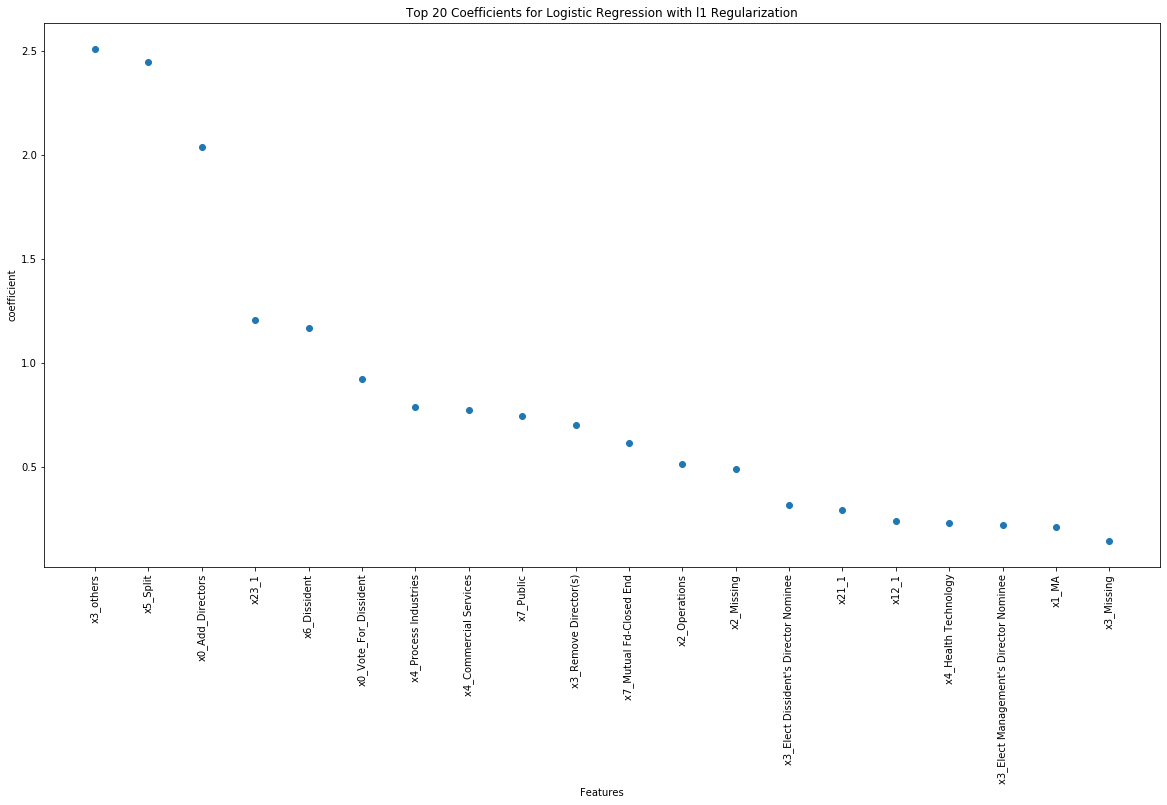

In [12]:
top_20_feature = plot_feature_importance(lg_l1_best,df,'Logistic Regression with l1 Regularization',x_train,y_train, use_coef = True)

In [13]:
top_20_feature

{'x3_others': 2.5115078135109945,
 'x5_Split': 2.4508540369168137,
 'x0_Add_Directors': 2.038780672183366,
 'x23_1': 1.2063579009632464,
 'x6_Dissident': 1.1709456628565675,
 'x0_Vote_For_Dissident': 0.9242645288487393,
 'x4_Process Industries': 0.7896221867696999,
 'x4_Commercial Services': 0.7740358423270498,
 'x7_Public': 0.744451243522482,
 'x3_Remove Director(s)': 0.7035031635988643,
 'x7_Mutual Fd-Closed End': 0.6153917772153014,
 'x2_Operations': 0.5148291748416616,
 'x2_Missing': 0.49253161882458046,
 "x3_Elect Dissident's Director Nominee": 0.31947448165877046,
 'x21_1': 0.294251084492854,
 'x12_1': 0.23953329046703975,
 'x4_Health Technology': 0.2296982052043088,
 "x3_Elect Management's Director Nominee": 0.2211671417935001,
 'x1_MA': 0.2122002320861907,
 'x3_Missing': 0.14452461359596888}

## Complete case

In [130]:
# Logistic regression
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
param_grid = {'C': np.logspace(-4, 4, 10)}
grid = GridSearchCV(lg_l1, param_grid, cv=2)
grid.fit(x_train_complete, y_train_complete)
lg_l1_complete_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

The best parameter for Logistic is {'C': 0.3593813663804626}
Training balanced accuracy for Logistic Regression is 0.63529
Testing balanced accuracy for Logistic Regression is 0.60553


In [131]:
# confusion_matrix with order: ['Management', 'Dissident']
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', grid) 
conf

array([[114,  79],
       [ 78, 127]])

In [132]:
pre_recall

,Precision,Recall
Management,0.593750,0.590674
Dissident,0.616505,0.619512


{'x3_others': 2.3749583712159588,
 'x0_Add_Directors': 2.0688003560653265,
 'x5_Split': 1.4469508184794448,
 'x6_Dissident': 1.1190693698162446,
 'x0_Vote_For_Dissident': 1.0018472168844268,
 'x4_Commercial Services': 0.7635926689610495,
 'x4_Process Industries': 0.7572713225346682,
 'x3_Remove Director(s)': 0.5749492613474648,
 'x7_Mutual Fd-Closed End': 0.5503013524656155,
 'x2_Operations': 0.48936358231880556,
 'x2_Missing': 0.4068678074642119,
 'x4_Health Technology': 0.27175764462776547,
 "x3_Elect Dissident's Director Nominee": 0.256063992685428,
 'x16_1': 0.19658812277831442,
 'x7_Public': 0.1732589129238508,
 'x1_MA': 0.12433047394914717,
 "x3_Elect Management's Director Nominee": 0.12180327245923861,
 'x3_Missing': 0.062312184929359825,
 'total_number_of_board_seats': 0.012384028403633377,
 'x21_1': 0.011588474120043749}

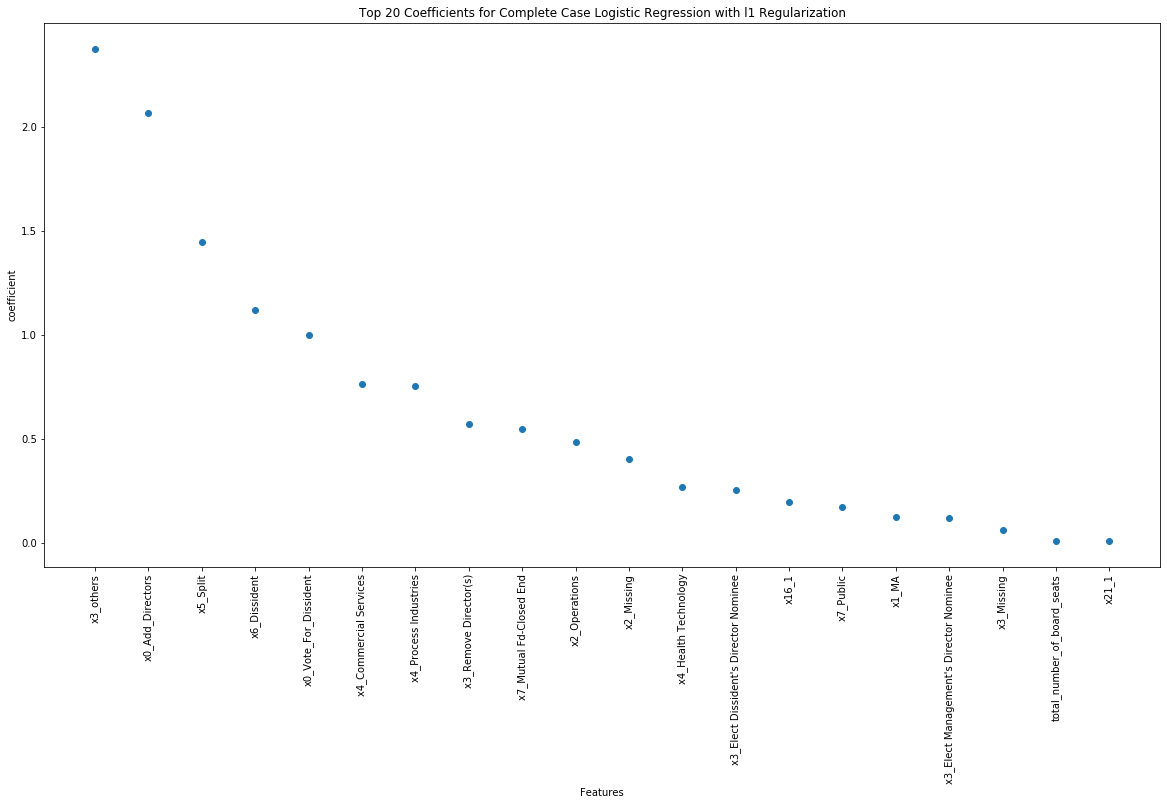

In [133]:
plot_feature_importance(grid.best_estimator_,df,'Complete Case Logistic Regression with l1 Regularization',x_train,y_train, use_coef = True)

In [138]:
cat_direction_assessment('x4_Process Industries',lg_l1_complete_best,x_train,combine_proxy,y = 'proxy_result')

                                    proxy_result
x4_Process Industries proxy_result              
0.0                   Missing               4030
                      Management            3969
                      Dissident             3951
1.0                   Missing                133
                      Dissident               69
                      Management              10


                                    proxy_result
x4_Process Industries proxy_result              
0                     Missing               4164
                      Dissident             4134
                      Management            4116


                                    proxy_result
x4_Process Industries proxy_result              
1                     Dissident             6526
                      Missing               4154
                      Management            1734


In [139]:
cat_direction_assessment('x4_Health Technology',lg_l1_complete_best,x_train,combine_proxy,y = 'proxy_result')


                                   proxy_result
x4_Health Technology proxy_result              
0.0                  Missing               3851
                     Management            3748
                     Dissident             3674
1.0                  Missing                311
                     Dissident              153
                     Management              58


                                   proxy_result
x4_Health Technology proxy_result              
0                    Missing               4164
                     Dissident             4133
                     Management            4117


                                   proxy_result
x4_Health Technology proxy_result              
1                    Dissident             5127
                     Missing               4165
                     Management            3122


## l2 penalty logistic regression

In [24]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')

param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

grid = GridSearchCV(lg_l2, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train, y_train)
lg_l2_best = grid.best_estimator_

print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'C': 2.782559402207126, 'solver': 'newton-cg'}
Training precision for Logistic Regression is 0.79946
Testing precision for Logistic Regression is 0.68975


In [25]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Dissident,0.556452,0.650943
Missing,0.982592,0.986408
Management,0.530201,0.417989


{'x3_others': 1.5146388067254388,
 'x24_0': 1.233383415004013,
 'x0_Add_Directors': 1.1904472265488424,
 'x5_Split': 1.1034582831124065,
 'x21_1': 0.7393700214380018,
 'x16_1': 0.7302873879701289,
 'x6_Dissident': 0.6621038691151973,
 'x11_1': 0.6492729363878821,
 'x25_0': 0.6269260562172673,
 'x4_Commercial Services': 0.6199923494614451,
 'x7_Public': 0.5463514218397851,
 'total_number_of_board_seats': 0.5008160440640194,
 'x19_0': 0.45364950671765963,
 'x3_Remove Director(s)': 0.4262395203190394,
 'x23_1': 0.42076493669112425,
 "x3_Elect Management's Director Nominee": 0.41707218623891845,
 "x3_Elect Dissident's Director Nominee": 0.41617312420324065,
 'x12_1': 0.3439438719864679,
 'x10_Yes': 0.34160140439704284,
 'x2_Missing': 0.2905405305406652}

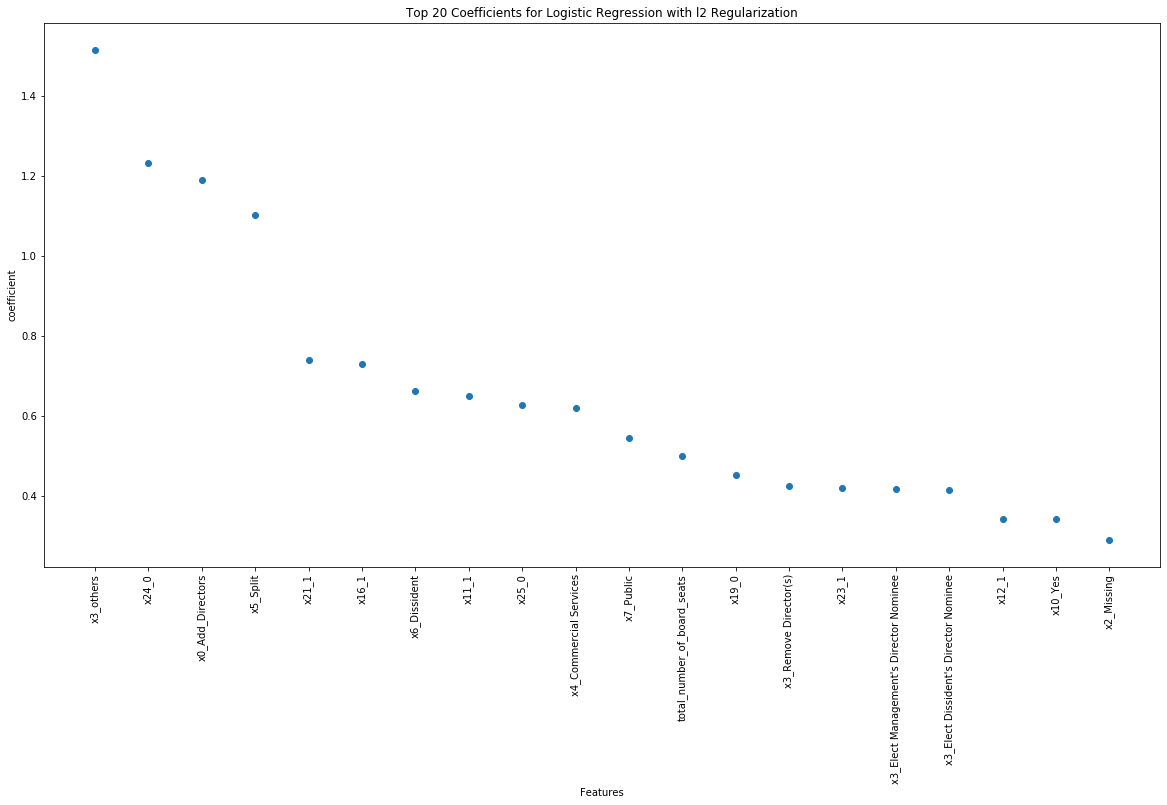

In [26]:
plot_feature_importance(lg_l2_best,df,'Logistic Regression with l2 Regularization',x_train,y_train,use_coef = True)

## Complete case

In [27]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')

# grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
grid = GridSearchCV(lg_l2, param_grid, cv=2)
grid.fit(x_train_complete, y_train_complete)
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train_complete, y_train_complete),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test_complete, y_test_complete),5)))

The best parameter for Logistic is {'C': 0.3593813663804626, 'solver': 'newton-cg'}
Training accuracy for Logistic Regression is 0.65294
Testing accuracy for Logistic Regression is 0.61055


In [28]:
conf, pre_recall = produce_confusion_matrix(x_test_complete, y_test_complete, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Management,0.598958,0.595855
Dissident,0.621359,0.624390


{'x3_others': 1.2685516490367443,
 'x0_Add_Directors': 1.020101025526884,
 'x24_0': 0.89801810422223,
 'x5_Split': 0.7706675324212033,
 'x16_1': 0.6425835416921933,
 'x6_Dissident': 0.6174539448654776,
 'x4_Commercial Services': 0.6044014134543404,
 'x21_1': 0.5707721439164869,
 'x25_0': 0.5543681354687844,
 'x11_1': 0.47677179213876475,
 'total_number_of_board_seats': 0.4678224964055338,
 'x3_Remove Director(s)': 0.39027225637901264,
 'x7_Public': 0.34654854383422085,
 'x7_Mutual Fd-Closed End': 0.3450658048644265,
 'x4_Process Industries': 0.34429730532393366,
 "x3_Elect Dissident's Director Nominee": 0.3424135273728019,
 'x23_1': 0.3405876262940892,
 "x3_Elect Management's Director Nominee": 0.32090402767764137,
 'x10_Yes': 0.2895927897617588,
 'x19_0': 0.2867591866277192}

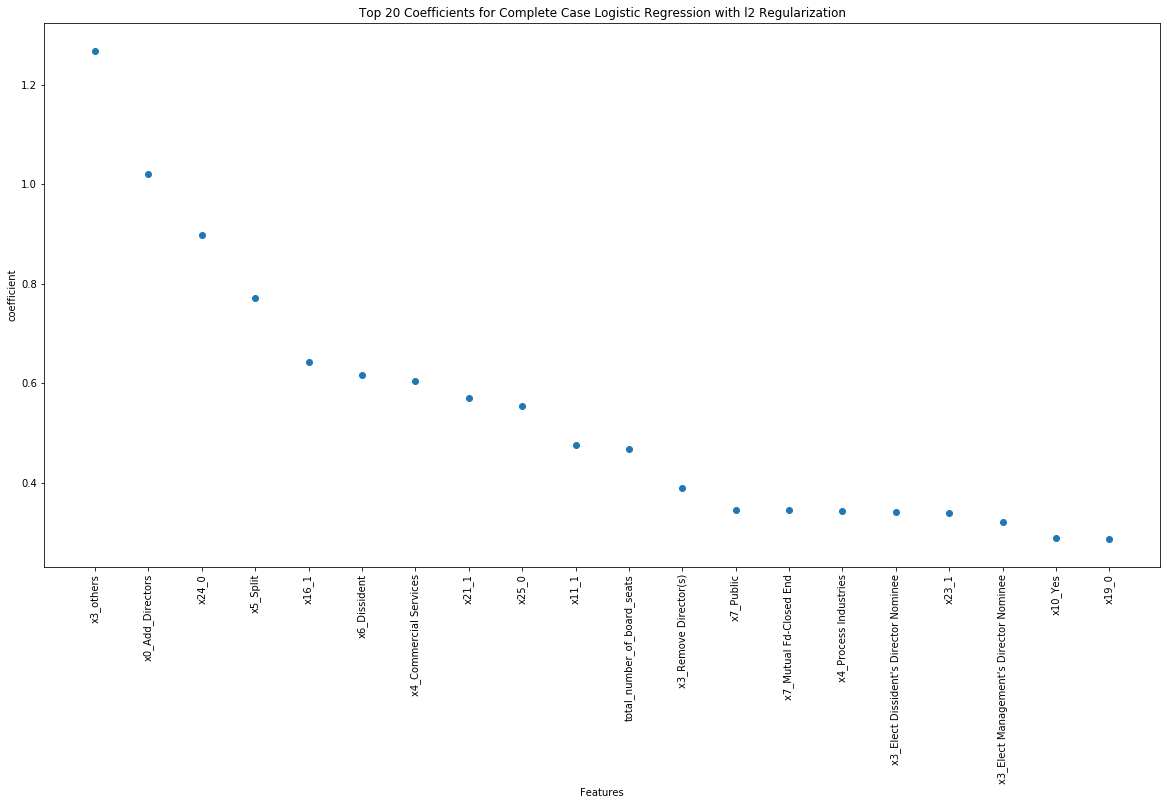

In [29]:
plot_feature_importance(grid.best_estimator_,df,'Complete Case Logistic Regression with l2 Regularization',x_train,y_train, use_coef = True)

## Random Forest

In [ ]:
# rf = RandomForestClassifier()
# param_grid = {'n_estimators': np.linspace(10, 500, 3).astype('int'),
#               'max_depth':np.linspace(10, 500, 3).astype('int'),
#               'min_samples_split':np.linspace(2, 50, 3).astype('int'),
#               'min_samples_leaf':np.linspace(1, 50, 3).astype('int'),
#               'bootstrap': [True, False],
#               'max_features': ['auto', 'sqrt'],
#              }

# grid = GridSearchCV(rf, param_grid, cv=2, scoring = 'precision_macro')
# grid.fit(x_train, y_train)
# print("The best parameter for Logistic is {}".format(grid.best_params_))
# print("Training precision for Random Forest is {}".format(round(precision_score(y_train, grid.predict(x_train),average='macro'),5)))
# print("Testing precision for Random Forest is {}".format(round(precision_score(y_test, grid.predict(x_test),average='macro'),5)))

### Note:
    Since training balanced accuracy is much higher than the testing one, we think the model with best paramters from grid search is overfitting. The following model prevents overfitting.

In [30]:
rf2 = RandomForestClassifier(bootstrap = False, 
                       max_depth = 4,
                       max_features = 'auto', 
                       min_samples_leaf = 10, 
                       min_samples_split = 10,
                       n_estimators = 100)
rf2.fit(x_train, y_train)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
from sklearn.metrics import precision_score
print("Training precision for Random Forest is {}".format(round(precision_score(y_train, rf2.predict(x_train),average='macro'),5)))
print("Testing precision for Random Forest is {}".format(round(precision_score(y_test, rf2.predict(x_test),average='macro'),5)))

Training precision for Random Forest is 0.80157
Testing precision for Random Forest is 0.70412


In [32]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', rf2) 
pre_recall

,Precision,Recall
Dissident,0.570281,0.669811
Missing,0.963947,0.986408
Management,0.578125,0.391534


{'x16_0': 0.21681313389016602,
 'x16_1': 0.11804357241942899,
 'x3_Missing': 0.11445869145119779,
 'total_number_of_board_seats': 0.08321875855770819,
 'x0_Add_Directors': 0.07129893322950946,
 'x0_Generic_Objective': 0.049179895609617504,
 'x15_0': 0.04564798449411601,
 "x3_Elect Dissident's Director Nominee": 0.03224435342952133,
 'x15_1': 0.031069855692163393,
 'x2_Missing': 0.025163782296781987,
 'x2_Board': 0.020047376736764145,
 'ownership_pecent_on_announcement': 0.01867141640595731,
 'x14_1': 0.015508259292485744,
 'x0_Vote_For_Dissident': 0.01439602941096313,
 'x14_0': 0.013108394463041358,
 'x11_0': 0.011195033702144747,
 'x0_Facilitate_MA': 0.00870535456575727,
 'x6_Missing': 0.008372267846699883,
 'x6_Management': 0.007564689894686741,
 'x24_1': 0.00718964439477157}

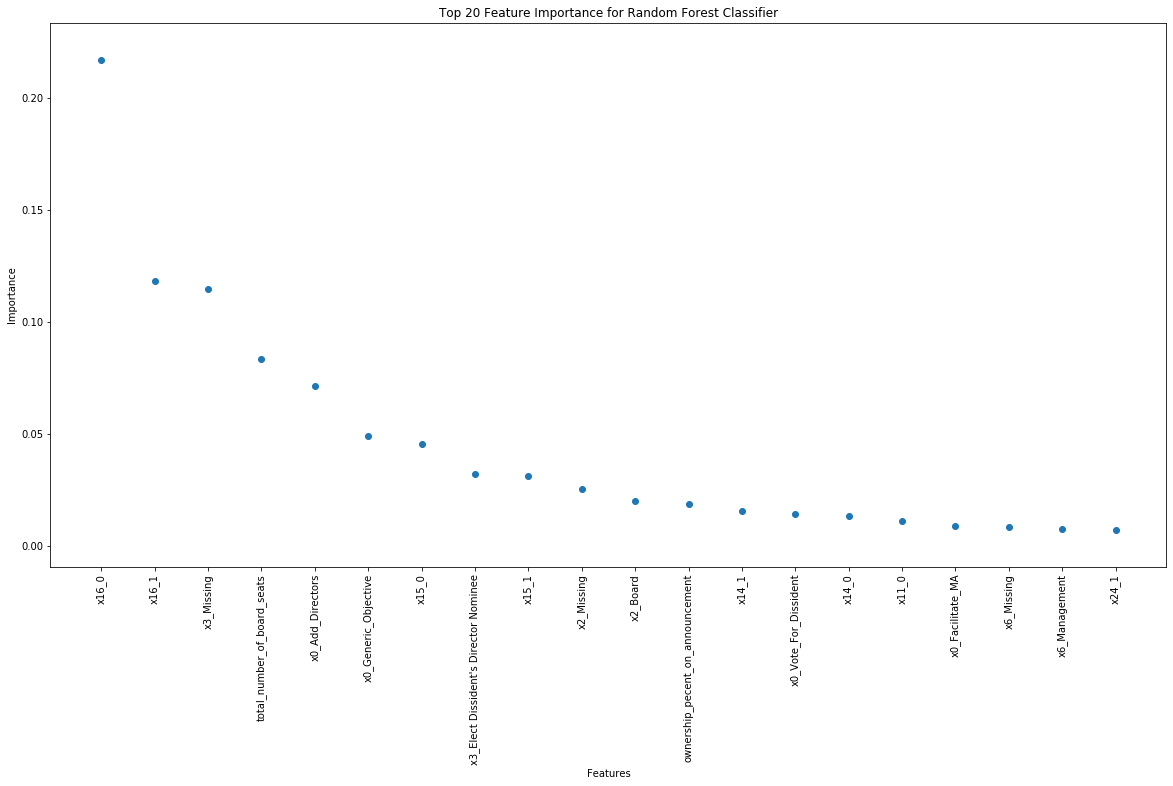

In [33]:
plot_feature_importance(rf2,df,'Random Forest Classifier',x_train,y_train,use_coef = False)

In [35]:
cat_direction_assessment('x16_0',rf2,x_train,combine_proxy,'proxy_result')

                    proxy_result
x16_0 proxy_result              
0.0   Dissident             3948
      Management            3374
      Missing                  6
1.0   Missing               4333
      Management             256
      Dissident               49


                    proxy_result
x16_0 proxy_result              
0     Dissident             4255
      Missing               4121
      Management            4038


                    proxy_result
x16_0 proxy_result              
1     Missing               5345
      Management            3770
      Dissident             3299


## Xgboost

In [36]:
# xgb = XGBClassifier()
# param_grid = {
#         'n_estimators':[100, 500], 
#         'min_child_weight': [5],
#         'gamma': [0, 1, 5],
#         'subsample': [0.8, 1.0],
#         'colsample_bytree': [0.3, 0.5, 0.8],
#         'max_depth': [3, 4, 5]
#         }

xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.3,
                      subsample = 0.8,
                      n_estimators=500, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10)

# param_test1 = {
#  'xgb__max_depth':range(3,10,2),
#  'xgb__min_child_weight':range(1,6,2)
# }
# grid = GridSearchCV(xgb, param_grid, cv=5, scoring = 'precision_macro')
xgb.fit(x_train, y_train)
# xgb_best = grid.best_estimators_
# print("The best parameter for xgboost is {}".format(grid.best_params_))
print("Training precision for xgboost is {}".format(round(precision_score(y_train, xgb.predict(x_train),average='macro'),5)))
print("Testing precision for xgboost is {}".format(round(precision_score(y_test, xgb.predict(x_test),average='macro'),5)))

Training precision for xgboost is 0.83067
Testing precision for xgboost is 0.69042


In [37]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', xgb) 
pre_recall

,Precision,Recall
Dissident,0.562500,0.636792
Missing,0.979730,0.985437
Management,0.529032,0.433862


{'x16_1': 0.13380833,
 'x16_0': 0.12401608,
 'x3_Missing': 0.06753899,
 'x0_Add_Directors': 0.063582346,
 'total_number_of_board_seats': 0.039913848,
 "x3_Elect Dissident's Director Nominee": 0.02141282,
 'x15_0': 0.02020817,
 'x2_Missing': 0.02011063,
 'x15_1': 0.0190831,
 'x0_Generic_Objective': 0.018918114,
 'x3_others': 0.01768093,
 'x2_Board': 0.013193889,
 'x0_Facilitate_MA': 0.013150715,
 'x14_0': 0.0129424,
 'x14_1': 0.012713274,
 'ownership_pecent_on_announcement': 0.012445846,
 'x6_Management': 0.011747701,
 'x21_1': 0.01135087,
 'x0_Vote_For_Dissident': 0.010778516,
 'x11_0': 0.010401551}

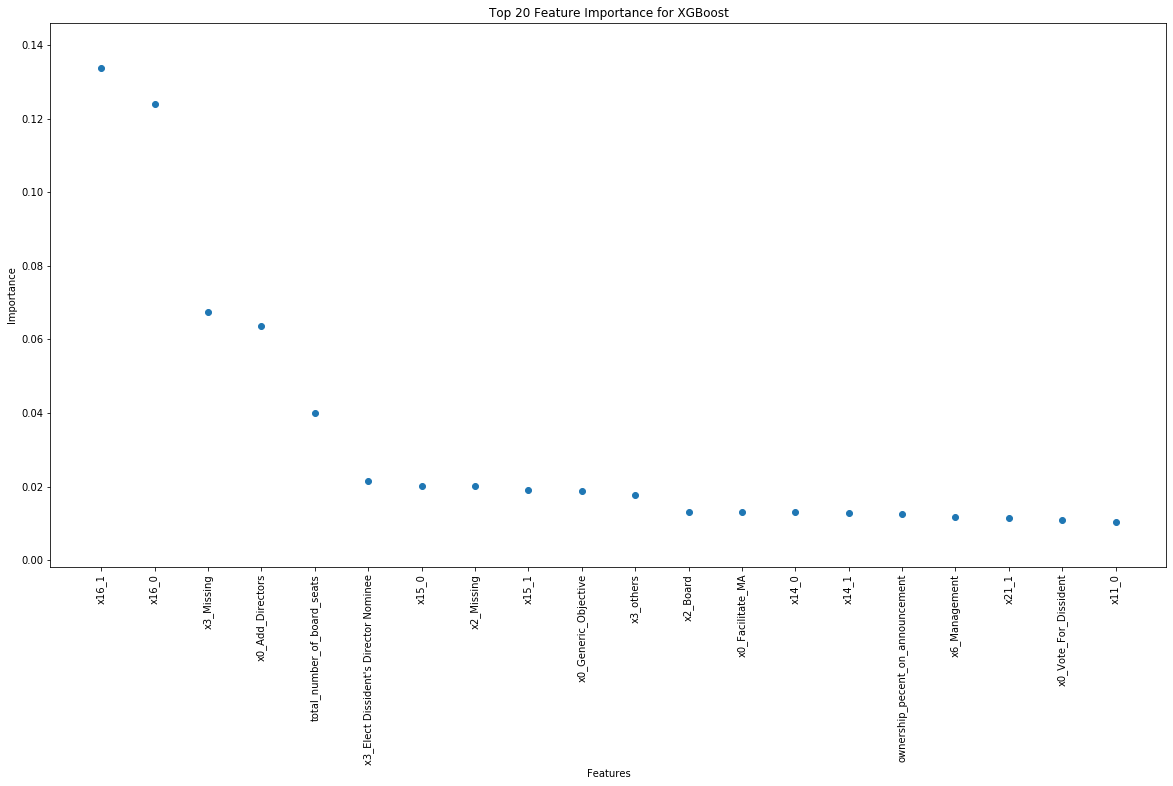

In [38]:
plot_feature_importance(xgb,df,'XGBoost', x_train,y_train,use_coef = False)

## Nearest Centroid

In [39]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5, scoring='precision_macro')
grid.fit(x_train, y_train)
nc_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training accuracy for Logistic Regression is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing accuracy for Logistic Regression is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for Logistic is {'metric': 'manhattan'}
Training accuracy for Logistic Regression is 0.64803
Testing accuracy for Logistic Regression is 0.61874


In [40]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', grid) 
pre_recall

,Precision,Recall
Dissident,0.494792,0.448113
Missing,0.957184,0.976699
Management,0.404255,0.402116


## Support Vector Matchine

In [41]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
# svm = OneVsRestClassifier(LinearSVC())
lin_svc = svm.LinearSVC()

param_grid = {'penalty':  ['l1','l2'],
              'C': np.linspace(0.00001,2,10),
              'loss':['squared_hinge'],
              'dual':[False]}

grid = GridSearchCV(lin_svc, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train, y_train)
lin_svc_best = grid.best_estimator_
print("The best parameter for SVM is {}".format(grid.best_params_))
print("Training mean precision for SVM is {}".format(round(grid.score(x_train, y_train),5)))
print("Testing mean precision for SVM is {}".format(round(grid.score(x_test, y_test),5)))

The best parameter for SVM is {'C': 0.2222311111111111, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Training mean precision for SVM is 0.79682
Testing mean precision for SVM is 0.69501


In [42]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result',lin_svc_best) 
pre_recall

,Precision,Recall
Dissident,0.559055,0.669811
Missing,0.985423,0.984466
Management,0.540541,0.423280


{'x3_others': 0.8269222833064879,
 'x5_Split': 0.706936576832965,
 'x0_Add_Directors': 0.6137412390102415,
 'x6_Dissident': 0.4442262248645198,
 'x23_1': 0.3277389449218956,
 'x0_Vote_For_Dissident': 0.29403984234257946,
 'x3_Remove Director(s)': 0.29270162033881725,
 'x4_Process Industries': 0.28520445540162787,
 'x4_Commercial Services': 0.26457118217980186,
 'x7_Mutual Fd-Closed End': 0.2614429832753646,
 'x2_Operations': 0.20412305740530434,
 'x2_Missing': 0.18076765454241958,
 'x21_1': 0.1470227950143414,
 "x3_Elect Dissident's Director Nominee": 0.12329793901836335,
 'x4_Health Technology': 0.08392133630881261,
 "x3_Elect Management's Director Nominee": 0.07692066645833713,
 'x7_Public': 0.07393027888623951,
 'x1_MA': 0.06873292645610382,
 'x16_1': 0.06409563636291328,
 'x12_1': 0.06241060460997226}

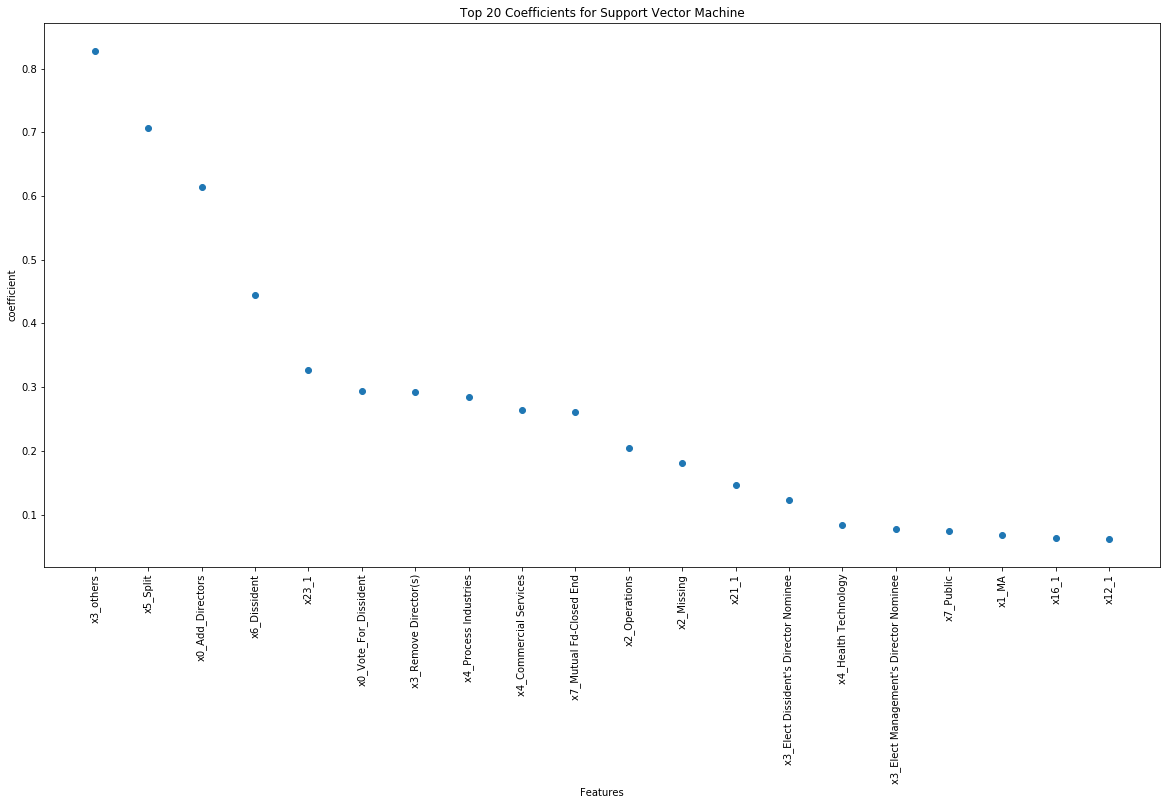

In [43]:
plot_feature_importance(lin_svc_best,df,'Support Vector Machine',  x_train,y_train,use_coef = True)

## Hard Vote

In [44]:
eclf1 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                    ('xgb', xgb), 
                                    ('nc', nc_best),
                                    ('svm', lin_svc_best)], 
                         voting='hard')
eclf1 = eclf1.fit(x_train, y_train)
y_pred1 = eclf1.predict(x_test)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred1 == np.array(y_test).flatten()) / len(y_pred1))*100))
print("Training precision for hard vote is {}".format(round(precision_score(y_train, eclf1.predict(x_train),average='macro'),5)))
print("Testing precision for hard vote is {}".format(round(precision_score(y_test, eclf1.predict(x_test),average='macro'),5)))

Training precision for hard vote is 0.80155
Testing precision for hard vote is 0.68677


In [45]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', eclf1) 
pre_recall

,Precision,Recall
Dissident,0.548148,0.698113
Missing,0.985437,0.985437
Management,0.526718,0.365079


## Soft Vote

In [46]:
eclf2 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                    ('xgb', xgb), 
#                                     ('nc', nc_best),
#                                     ('svm', lin_svc_best)
                                    ], 
                         voting='soft')
eclf2 = eclf2.fit(x_train, y_train)
y_pred2 = eclf2.predict(x_test)
print("Training precision for soft vote is {}".format(round(precision_score(y_train, eclf2.predict(x_train),average='macro'),5)))
print("Testing precision for soft vote is {}".format(round(precision_score(y_test, eclf2.predict(x_test),average='macro'),5)))

Training precision for soft vote is 0.80928
Testing precision for soft vote is 0.69825


In [47]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', eclf2) 
pre_recall

,Precision,Recall
Dissident,0.569170,0.679245
Missing,0.984496,0.986408
Management,0.541096,0.417989


## Weights Based Weights Soft Vote

In [48]:
compute_weights = lambda pipelines,x_train,y_train,x_test,y_test: [x.fit(x_train,y_train).score(x_test,y_test) for x in pipelines]
ensemble = [lg_l1_best,lg_l2_best,rf2,xgb]
weights = compute_weights(ensemble,x_train,y_train,x_test,y_test)

eclf3 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                    ('xgb', xgb)], 
                                     voting='soft', 
                                     weights=weights,
                                     flatten_transform=True)
eclf3 = eclf3.fit(x_train, y_train)
y_pred3 = eclf3.predict(x_test)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test).flatten()) / len(y_pred3))*100))
print("Training precision for soft vote is {}".format(round(precision_score(y_train, eclf3.predict(x_train),average='macro'),5)))
print("Testing precision for soft vote is {}".format(round(precision_score(y_test, eclf3.predict(x_test),average='macro'),5)))

Training precision for soft vote is 0.80924
Testing precision for soft vote is 0.69858


In [49]:
conf, pre_recall = produce_confusion_matrix(x_test, y_test, 'proxy_result', eclf3) 
pre_recall

,Precision,Recall
Dissident,0.569170,0.679245
Missing,0.985465,0.987379
Management,0.541096,0.417989


# Seat_gained_success

## l1 penalty logistic regression

In [50]:
# Logistic regression with l1 norm
lg_l1 = LogisticRegression(penalty = 'l1',multi_class = 'auto')

# , solver = 'saga'
# Perform grid search
# param_grid = {'C': np.linspace(0.00000000000001, 2, 3)}
# param_grid = {'C': np.logspace(-4, 4, 10)}
param_grid = {'C': np.linspace(0.00000000000001, 30, 5),
             'solver': ['saga','liblinear']}
grid = GridSearchCV(lg_l1, param_grid, cv=2, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)

lg_l1_best = grid.best_estimator_

print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training precision for Logistic Regression is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing precision for Logistic Regression is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))


The best parameter for Logistic is {'C': 7.500000000000007, 'solver': 'liblinear'}
Training precision for Logistic Regression is 0.64602
Testing precision for Logistic Regression is 0.43527


In [51]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',grid) 
pre_recall

,Precision,Recall
Partial_success,0.287356,0.416667
Fail,0.640394,0.601852
Success,0.378049,0.322917


{'x3_others': 5.711363082986641,
 "x3_Elect Management's Director Nominee": 4.9477799221452745,
 'x3_Remove Director(s)': 4.777149732074189,
 'x3_Missing': 4.759338156727635,
 "x3_Elect Dissident's Director Nominee": 4.63091454936765,
 'x4_Consumer Durables': 4.627888232018671,
 'x4_Health Services': 4.519138483159531,
 'x4_Miscellaneous': 4.358450775842182,
 'x4_Energy Minerals': 4.122271824814254,
 'x4_Communications': 3.722334907610882,
 'x4_Industrial Services': 3.629539230723113,
 'x4_Transportation': 3.4055737063885303,
 'x4_Missing': 3.3618388123993053,
 'x4_Consumer Non-Durables': 3.35281923556409,
 'x4_Consumer Services': 3.346247810076247,
 'x4_Utilities': 3.2640332576599085,
 'x4_Finance': 3.249459115659159,
 'x4_Producer Manufacturing': 3.1122354335163975,
 'x4_Electronic Technology': 3.07233401569476,
 'x4_Health Technology': 2.9926679524211193}

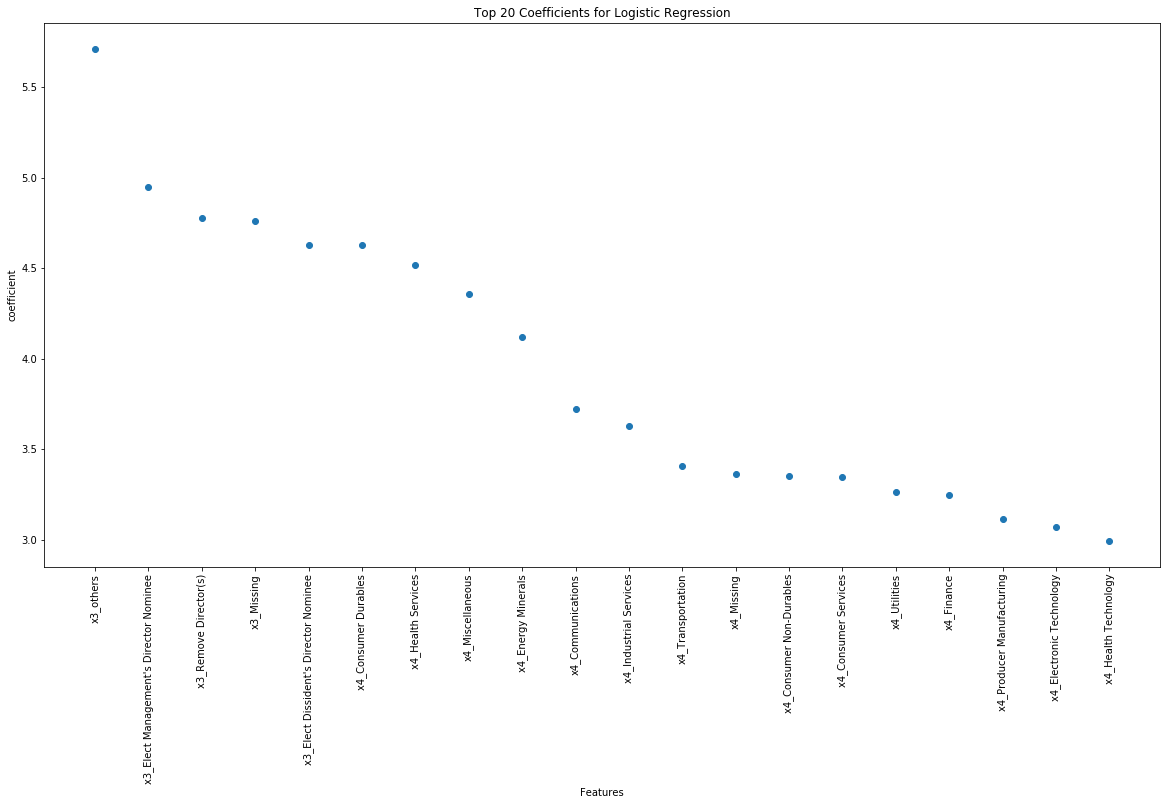

In [81]:
plot_feature_importance(lg_l1_best,df_board_seats,'Logistic Regression',x_train_seat,y_train_seat)

In [84]:
cat_direction_assessment("x3_Elect Management's Director Nominee",lg_l1_best,x_train_seat,combine_seat)

                                                                  board_seat_gained_success
x3_Elect Management's Director Nominee board_seat_gained_success                           
0.0                                    Partial_success                                  842
                                       Success                                          693
                                       Fail                                             683
1.0                                    Fail                                             120
                                       Success                                           81
                                       Partial_success                                   41


                                                                  board_seat_gained_success
x3_Elect Management's Director Nominee board_seat_gained_success                           
0                                      Partial_success                        

## l2 penalty logistic regression

In [85]:
# Logistic regression with l2 norm
lg_l2 = LogisticRegression(penalty = 'l2',multi_class = 'auto')
param_grid = {'C': np.logspace(-4, 4, 10),
             'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
grid = GridSearchCV(lg_l2, param_grid, cv=2, scoring = 'balanced_accuracy')
grid.fit(x_train_seat, y_train_seat)
lg_l2_best = grid.best_estimator_
print("The best parameter for Logistic is {}".format(grid.best_params_))
print("Training balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing balanced accuracy for Logistic Regression is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Logistic is {'C': 0.3593813663804626, 'solver': 'newton-cg'}
Training balanced accuracy for Logistic Regression is 0.6435
Testing balanced accuracy for Logistic Regression is 0.46481


In [86]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',grid) 
pre_recall

,Precision,Recall
Partial_success,0.281250,0.450000
Fail,0.664865,0.569444
Success,0.395604,0.375000


{'x4_Energy Minerals': 1.3999923338480063,
 'x4_Consumer Durables': 1.3815476833232352,
 'x3_others': 1.3797729063995954,
 'x4_Miscellaneous': 1.375279851181966,
 'x4_Health Services': 1.31608799657926,
 'x4_Finance': 1.125566939396094,
 'x4_Communications': 1.051400549154526,
 'x4_Industrial Services': 1.003961049187919,
 'x4_Consumer Services': 1.0009289177302814,
 "x3_Elect Management's Director Nominee": 0.9422622118176304,
 'x3_Remove Director(s)': 0.9379678215917581,
 'x4_Consumer Non-Durables': 0.9053399936315525,
 'x4_Electronic Technology': 0.8942142215237587,
 'x4_Producer Manufacturing': 0.8793782540846472,
 'x3_Missing': 0.8465194915300368,
 'x4_Health Technology': 0.8406089843004321,
 'x4_Transportation': 0.8374572088774446,
 'x4_Utilities': 0.7590678992960043,
 'x4_Technology Services': 0.7563236343393352,
 "x3_Elect Dissident's Director Nominee": 0.7484306229087714}

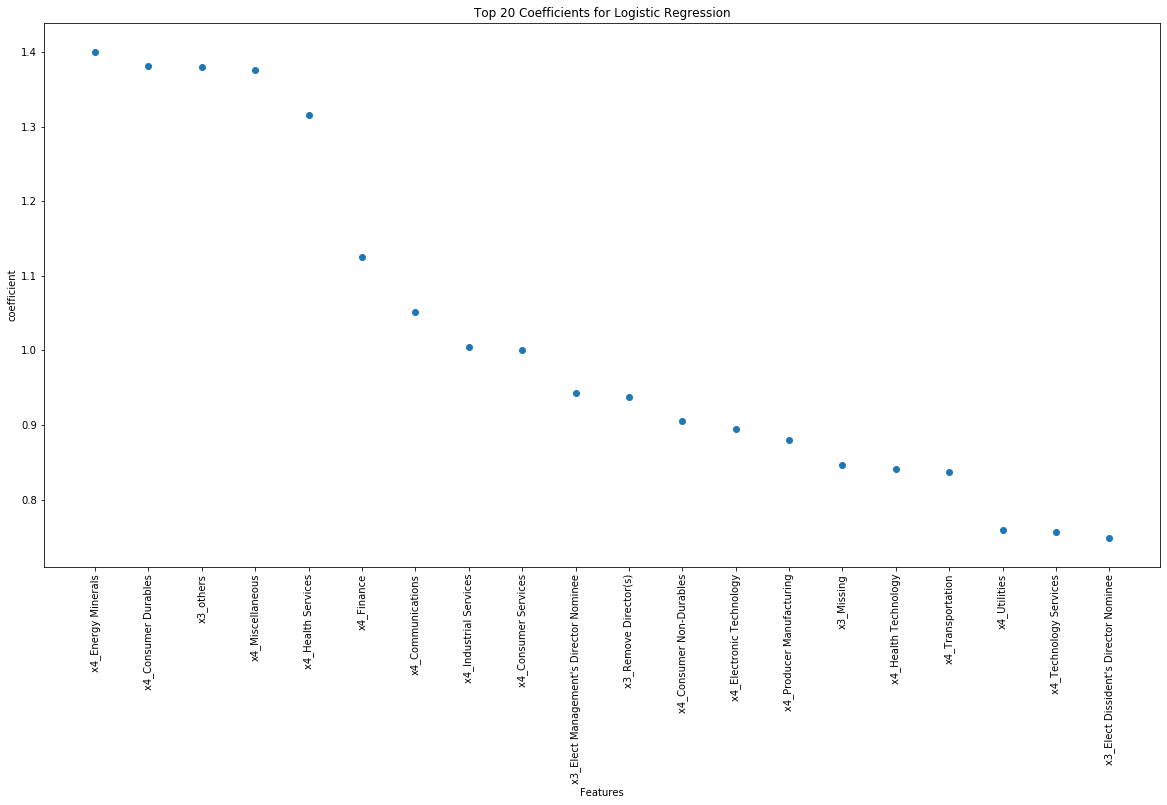

In [90]:
plot_feature_importance(lg_l2_best,df_board_seats,'Logistic Regression',x_train_seat,y_train_seat)

In [145]:
cat_direction_assessment("x3_Remove Director(s)",lg_l1_best,x_train_seat,combine_seat)

                                                 board_seat_gained_success
x3_Remove Director(s) board_seat_gained_success                           
0.0                   Partial_success                                  882
                      Fail                                             762
                      Success                                          703
1.0                   Success                                           70
                      Fail                                              41
                      Partial_success                                    2


                                                 board_seat_gained_success
x3_Remove Director(s) board_seat_gained_success                           
0                     Partial_success                                  892
                      Success                                          806
                      Fail                                             762


                     

## Random Forest

In [ ]:
# rf = RandomForestClassifier()
# param_grid = {'n_estimators': np.linspace(10, 500, 3).astype('int'),
#               'max_depth':np.linspace(10, 500, 3).astype('int'),
#               'min_samples_split':np.linspace(2, 50, 3).astype('int'),
#               'min_samples_leaf':np.linspace(1, 50, 3).astype('int'),
#               'bootstrap': [True, False],
#               'max_features': ['auto', 'sqrt'],
#              }

# grid = GridSearchCV(rf, param_grid, cv=2, scoring = 'balanced_accuracy')
# grid.fit(x_train_seat, y_train_seat)
# print("The best parameter for Logistic is {}".format(grid.best_params_))
# print("Training balanced accuracy for Random Forest is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
# print("Testing balanced accuracy for Random Forest is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

### Note:
    Since training balanced accuracy is much higher than the testing one, we think the model with best paramters from grid search is overfitting. The following model prevents overfitting.

In [91]:
rf2 = RandomForestClassifier(bootstrap = False, 
                       max_depth = 5,
                       max_features = 'auto', 
                       min_samples_leaf = 10, 
                       min_samples_split = 10,
                       n_estimators = 100)
rf2.fit(x_train_seat, y_train_seat)


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [92]:
from sklearn.metrics import balanced_accuracy_score
print("Training precision for Random Forest is {}".format(round(precision_score(y_train_seat, rf2.predict(x_train_seat),average = 'macro'),5)))
print("Testing precision accuracy for Random Forest is {}".format(round(precision_score(y_test_seat, rf2.predict(x_test_seat),average = 'macro'),5)))

Training precision for Random Forest is 0.69236
Testing precision accuracy for Random Forest is 0.43292


In [93]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', rf2) 
pre_recall

,Precision,Recall
Partial_success,0.277311,0.550000
Fail,0.658960,0.527778
Success,0.362500,0.302083


{'ownership_pecent_on_announcement': 0.09551918799731815,
 'pre_12m_earnings_yield': 0.07614185698930365,
 'pre_6m_earnings_yield': 0.06881038271521712,
 'x6_Dissident': 0.059669033294990854,
 'price_at_announcement': 0.05563700859028674,
 'earnings_yield_at_announcement': 0.05480502860434694,
 'x4_Miscellaneous': 0.04043685474369857,
 'total_number_of_board_seats': 0.03950456790103983,
 'pre_3m_earnings_yield': 0.03631278812936649,
 'x3_Missing': 0.03418809557683528,
 'x6_Missing': 0.027238922144997887,
 'pre_18m_residual_return': 0.02662476881534197,
 'ltm_eps_at_announcement': 0.025811940640381347,
 'pre_18m_earnings_yield': 0.022211583613684124,
 'x18_0': 0.02053060401851554,
 'x18_1': 0.019873100703128563,
 'x4_Finance': 0.017303326797383736,
 'pre_12m_residual_return': 0.016745136725676145,
 'x25_1': 0.014669699269137415,
 'x25_0': 0.014023429637170064}

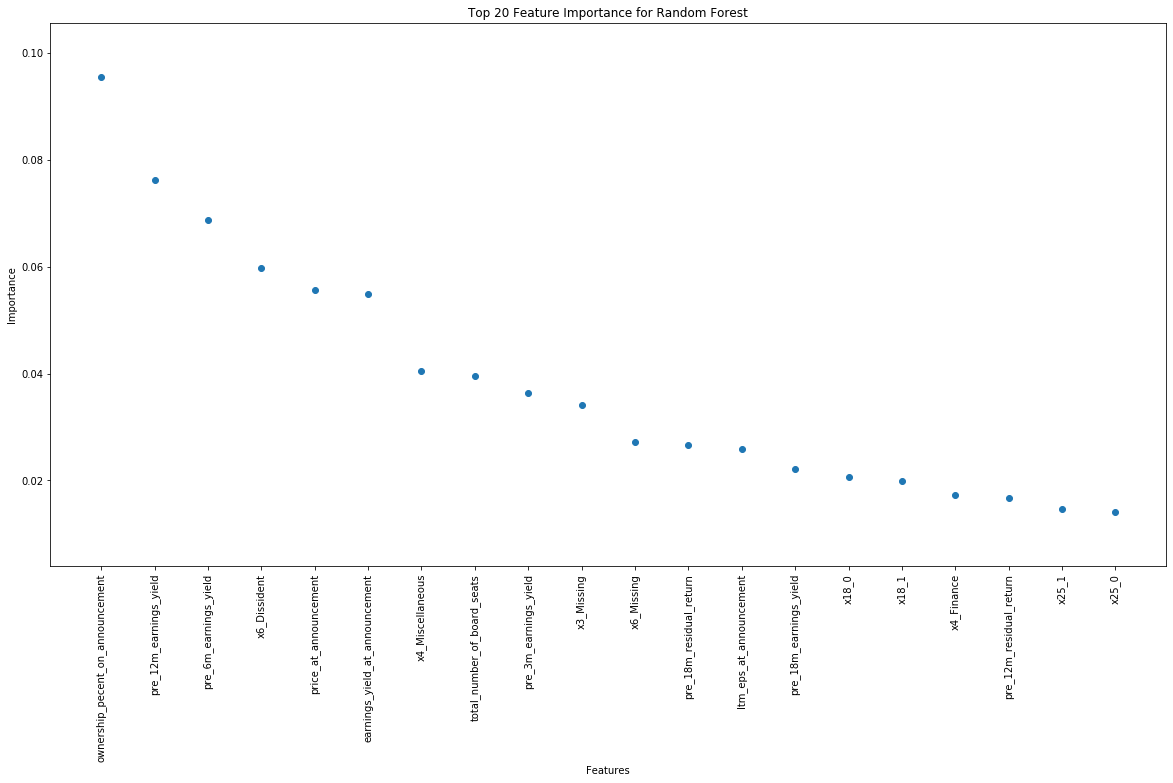

In [94]:
plot_feature_importance(rf2,df_board_seats,'Random Forest',x_train_seat,y_train_seat, False)

In [140]:
cat_direction_assessment('x4_Miscellaneous',lg_l1_best,x_train_seat,combine_seat)

                                            board_seat_gained_success
x4_Miscellaneous board_seat_gained_success                           
0.0              Partial_success                                  883
                 Success                                          729
                 Fail                                             648
1.0              Fail                                             150
                 Success                                           32
                 Partial_success                                    1


                                            board_seat_gained_success
x4_Miscellaneous board_seat_gained_success                           
0                Partial_success                                  968
                 Success                                          832
                 Fail                                             660


                                            board_seat_gained_success
x4_Miscellaneous

In [143]:
cat_direction_assessment('x6_Dissident',lg_l1_best,x_train_seat,combine_seat)

                                        board_seat_gained_success
x6_Dissident board_seat_gained_success                           
0.0          Partial_success                                  822
             Fail                                             777
             Success                                          520
1.0          Success                                          188
             Partial_success                                   28
             Fail                                              22


                                        board_seat_gained_success
x6_Dissident board_seat_gained_success                           
0            Partial_success                                  976
             Fail                                             920
             Success                                          564


                                        board_seat_gained_success
x6_Dissident board_seat_gained_success                           
1     

# Multi-layer Perceptron classifier

In [95]:
from sklearn.neural_network import MLPClassifier

In [96]:
MLP = MLPClassifier(early_stopping = True)
param_grid = {'hidden_layer_sizes': [(256,128,64),(256,128)],
              'alpha': np.linspace(0,2,5)}
grid = GridSearchCV(MLP, param_grid = param_grid, cv = 5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
MLP_best = grid.best_estimator_
print("The best parameter for Nerual Netis {}".format(grid.best_params_))
print("Training mean precision for Nerual Net is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for Nerual Net is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Nerual Netis {'alpha': 0.0, 'hidden_layer_sizes': (256, 128)}
Training mean precision for Nerual Net is 0.61503
Testing mean precision for Nerual Net is 0.47077


In [97]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.260870,0.400000
Fail,0.748344,0.523148
Success,0.403101,0.541667


# Classifier using Ridge regression

In [100]:
from sklearn.linear_model import RidgeClassifier

In [101]:
Ridge = RidgeClassifier()
param_grid = {'alpha':  np.linspace(0, 2, 20)}

grid = GridSearchCV(Ridge, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
ridge_best = grid.best_estimator_
print("The best parameter for Ridge Discriminant Analysis is {}".format(grid.best_params_))
print("Training mean precision for Ridge is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for Ridge is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Ridge Discriminant Analysis is {'alpha': 1.4736842105263157}
Training mean precision for Ridge is 0.63683
Testing mean precision for Ridge is 0.43708


In [102]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.28000,0.466667
Fail,0.65625,0.583333
Success,0.37500,0.312500


{'x4_Consumer Durables': 1.1670665389151593,
 'x4_Health Services': 1.1443005377842157,
 'x4_Energy Minerals': 1.0410132042091005,
 'x4_Miscellaneous': 1.0312253231784498,
 'x4_Communications': 0.8487064962494055,
 'x4_Industrial Services': 0.7641581298383169,
 'x3_others': 0.7292818634814684,
 'x4_Consumer Services': 0.6803251133913937,
 'x4_Finance': 0.6731035019453597,
 'x4_Consumer Non-Durables': 0.6660114798055874,
 'x4_Transportation': 0.6316742880678269,
 'x4_Utilities': 0.6004156443058063,
 'x4_Producer Manufacturing': 0.591013528728401,
 'x4_Electronic Technology': 0.5590410800643622,
 'x4_Health Technology': 0.5561388973931646,
 'x4_Non-Energy Minerals': 0.5179099872516639,
 'x4_Distribution Services': 0.514550728224714,
 'x4_Technology Services': 0.5082027384531895,
 'x4_Commercial Services': 0.4852113108151671,
 'x4_Missing': 0.47890880057042384}

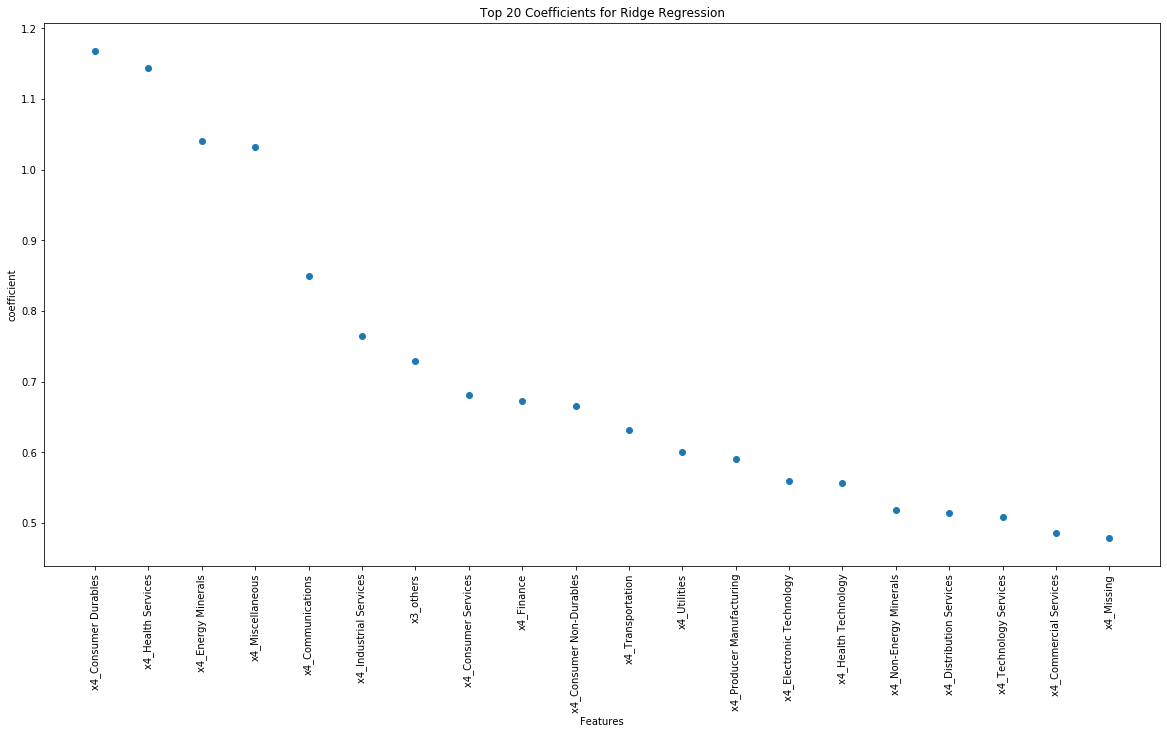

In [105]:
plot_feature_importance(ridge_best,df_board_seats,'Ridge Regression',x_train_seat,y_train_seat)

## Xgboost

In [106]:
xgb = XGBClassifier()
param_grid = {
        'n_estimators':[100, 500], 
        'min_child_weight': [5],
        'gamma': [0, 1, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.3, 0.5, 0.8],
        'max_depth': [3, 4, 5]
        }
param_grid = {'n_estimators':[500]}

# model = XGBClassifier(silent=False, 
#                       scale_pos_weight=1,
#                       learning_rate=0.01,  
#                       colsample_bytree = 0.4,
#                       subsample = 0.8,
#                       objective='binary:logistic', 
#                       n_estimators=1000, 
#                       reg_alpha = 0.3,
#                       max_depth=4, 
#                       gamma=10)

# param_test1 = {
#  'xgb__max_depth':range(3,10,2),
#  'xgb__min_child_weight':range(1,6,2)
# }
grid = GridSearchCV(xgb, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
xgb_best = grid.best_estimator_
print("The best parameter for xgboost is {}".format(grid.best_params_))
print("Training accuracy for xgboost is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing accuracy for xgboost is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))


The best parameter for xgboost is {'n_estimators': 500}
Training accuracy for xgboost is 0.9687
Testing accuracy for xgboost is 0.43507


In [107]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.338462,0.366667
Fail,0.618257,0.689815
Success,0.348485,0.239583


{'x4_Miscellaneous': 0.047669474,
 'x6_Dissident': 0.047007404,
 'x25_0': 0.03349324,
 'x18_0': 0.032527067,
 'x4_Finance': 0.031322498,
 'x6_Management': 0.031033495,
 'x1_Missing': 0.030031022,
 'x3_Missing': 0.029953597,
 'x2_Operations': 0.027560523,
 'x11_0': 0.022934513,
 'x6_Missing': 0.020729538,
 'x1_MA': 0.020529341,
 'x3_others': 0.020293312,
 'x7_Mutual Fd-Closed End': 0.018222949,
 'ownership_pecent_on_announcement': 0.017619627,
 'x5_Split': 0.01682943,
 'x10_No': 0.016562201,
 'x7_Extinct': 0.016537027,
 'total_number_of_board_seats': 0.016249757,
 'pre_12m_earnings_yield': 0.015855523}

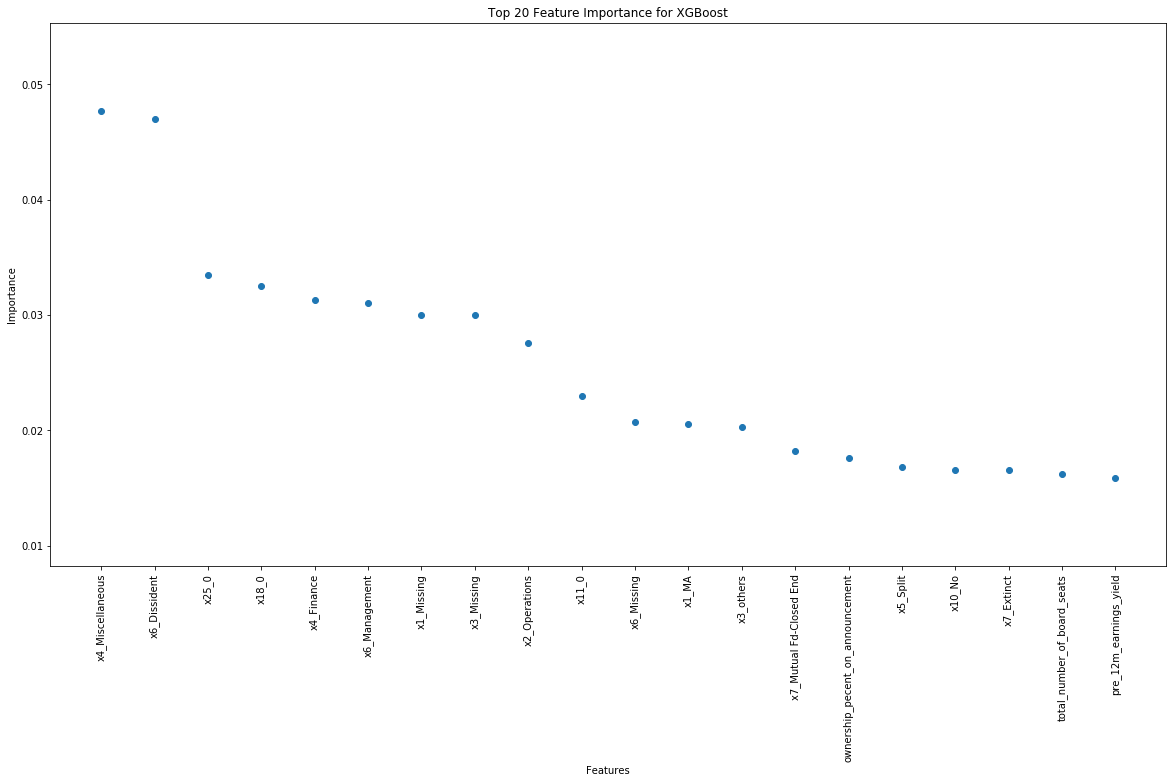

In [109]:
plot_feature_importance(xgb_best,df_board_seats,'XGBoost',x_train_seat,y_train_seat,False)

## Nearest Centroid

In [110]:
nc = NearestCentroid()
param_grid = {'metric':['euclidean','manhattan']}
grid = GridSearchCV(nc, param_grid, cv=5)
grid.fit(x_train_seat, y_train_seat)
nc_best = grid.best_estimator_

print("The best parameter for Nearest Centroid is {}".format(grid.best_params_))
print("Training accuracy for Nearest Centroid is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing accuracy for Nearest Centroid is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Nearest Centroid is {'metric': 'euclidean'}
Training accuracy for Nearest Centroid is 0.44472
Testing accuracy for Nearest Centroid is 0.30376


In [111]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',grid) 
pre_recall

,Precision,Recall
Partial_success,0.191964,0.716667
Fail,0.589474,0.259259
Success,0.264151,0.145833


## Support Vector Matchine

In [112]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
# svm = OneVsRestClassifier(LinearSVC())
lin_svc = svm.LinearSVC()

param_grid = {'penalty':  ['l1','l2'],
              'C': np.linspace(0.00001,2,5),
              'loss':['squared_hinge'],
              'dual':[False]}

grid = GridSearchCV(lin_svc, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
lin_svc_best = grid.best_estimator_
print("The best parameter for SVM is {}".format(grid.best_params_))
print("Training mean precision for SVM is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for SVM is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for SVM is {'C': 1.5000025, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l1'}
Training mean precision for SVM is 0.63988
Testing mean precision for SVM is 0.43128


In [113]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 

In [114]:
pre_recall

,Precision,Recall
Partial_success,0.263158,0.416667
Fail,0.647959,0.587963
Success,0.382716,0.322917


# Ada boost

In [115]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
param_grid = {'n_estimators':  np.linspace(200,400,5).astype('int')}

grid = GridSearchCV(ada, param_grid, cv=5, scoring = 'precision_macro')
grid.fit(x_train_seat, y_train_seat)
ada_best = grid.best_estimator_
print("The best parameter for Adapative Boosting is {}".format(grid.best_params_))
print("Training mean precision for Adapative Boosting is {}".format(round(grid.score(x_train_seat, y_train_seat),5)))
print("Testing mean precision for Adapative Boosting is {}".format(round(grid.score(x_test_seat, y_test_seat),5)))

The best parameter for Adapative Boosting is {'n_estimators': 250}
Training mean precision for Adapative Boosting is 0.72909
Testing mean precision for Adapative Boosting is 0.42834


In [116]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success', grid) 
pre_recall

,Precision,Recall
Partial_success,0.294872,0.383333
Fail,0.613333,0.638889
Success,0.376812,0.270833


## Hard Vote

In [117]:
eclf = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                     ('xgb', xgb),
                                     ('MLP',MLP_best),
                                     ('ridge',ridge_best),
                                     ('svm',lin_svc_best),
                                     ('ada',ada_best),
                                     ('nc',nc_best)], 
                                     voting='hard')
eclf = eclf.fit(x_train_seat, y_train_seat)
y_pred = eclf.predict(x_test_seat)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred == np.array(y_test_seat).flatten()) / len(y_pred))*100))

In [118]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',eclf) 
pre_recall

,Precision,Recall
Partial_success,0.297872,0.466667
Fail,0.653659,0.620370
Success,0.410959,0.312500


## Soft Vote

In [119]:
eclf2 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                     ('xgb', xgb),
                                     ('MLP',MLP_best),
                                     ('ada',ada_best)], 
                                     voting='soft')
eclf2 = eclf2.fit(x_train_seat, y_train_seat)
y_pred2 = eclf2.predict(x_test_seat)
# print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test_seat).flatten()) / len(y_pred3))*100))

In [120]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',eclf2) 
pre_recall

,Precision,Recall
Partial_success,0.303371,0.450000
Fail,0.679144,0.587963
Success,0.395833,0.395833


## Weights Based Weights Soft Vote

In [121]:
compute_weights = lambda pipelines,x_train_seat,y_train_seat,x_test_seat,y_test_seat: [x.fit(x_train_seat,y_train_seat).score(x_test_seat,y_test_seat) for x in pipelines]
ensemble = [lg_l1_best,lg_l2_best,rf2,xgb,MLP_best,ada_best]
weights = compute_weights(ensemble,x_train_seat,y_train_seat,x_test_seat,y_test_seat)

eclf3 = VotingClassifier(estimators=[('lg', lg_l1_best), 
                                     ('lg2', lg_l2_best), 
                                     ('rf', rf2),
                                     ('xgb', xgb),
                                     ('MLP',MLP_best),
                                     ('ada',ada_best)], 
                                     voting='soft', 
                                     weights=weights,
                                     flatten_transform=True)
eclf3 = eclf3.fit(x_train_seat, y_train_seat)
y_pred3 = eclf3.predict(x_test_seat)
print("Accuracy is %.2f%%" % ((np.sum(y_pred3 == np.array(y_test_seat).flatten()) / len(y_pred3))*100))

Accuracy is 53.23%


In [122]:
conf, pre_recall = produce_confusion_matrix(x_test_seat, y_test_seat,'seat_gained_success',eclf3) 
pre_recall

,Precision,Recall
Partial_success,0.329268,0.450000
Fail,0.648889,0.675926
Success,0.384615,0.260417
